In [1]:
%matplotlib inline

In [2]:
PACKAGE_NAME = 'exercise_classifier_AdamW_with_CosineLR'

TEST_SPLIT = 0.10
SEQUENCE_SIZE = 32

BATCH_SIZE = 128
ITERATION_SIZE = 100000
OPTIMIZER = 'AdamW' # 'SGD' or 'AdamW'
LEARNING_RATE_SCHEDULER = 'CosineAnnealingLR' # 'None' or 'LambdaLR' or 'CosineAnnealingWarmRestarts' or 'CosineAnnealingLR'

1. 데이터 초기화

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [6]:
df = pd.read_csv('/content/drive/Shareddrives/ML_TeamProject/train.csv')

In [7]:
df.reset_index()
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y,angle,exercise
0,image/babel_dumbel/193/193-1-1-09-Z2_C/193-1-1...,995.28880,304.97345,1008.65216,292.45782,975.24380,298.71560,1022.01550,304.97345,961.88043,...,995.28880,455.16095,995.28880,536.51250,1035.37880,880.69214,941.83550,874.43440,C,프런트 레이즈
1,image/babel_dumbel/193/193-1-1-09-Z2_C/193-1-1...,993.84845,307.58905,1007.13180,295.12967,973.92350,301.35938,1020.41510,301.35938,960.64020,...,993.84845,457.10156,993.84845,531.85780,1033.69850,880.72034,940.71515,874.49060,C,프런트 레이즈
2,image/babel_dumbel/193/193-1-1-09-Z2_C/193-1-1...,988.64720,303.63750,995.44885,297.25310,975.04376,297.25310,1015.85394,310.02188,954.63870,...,995.44885,437.70935,995.44885,527.09064,1036.25900,878.23126,941.03520,884.61560,C,프런트 레이즈
3,image/babel_dumbel/193/193-1-1-09-Z2_C/193-1-1...,988.72720,302.99063,1002.81070,296.36720,967.60187,296.36720,1016.89420,309.61407,960.56020,...,995.76890,442.08282,995.76890,521.56410,1038.01950,885.85315,932.39307,885.85315,C,프런트 레이즈
4,image/babel_dumbel/193/193-1-1-09-Z2_C/193-1-1...,991.28784,305.85938,991.28784,292.52814,969.92255,292.52814,1019.77496,312.52500,955.67890,...,998.40960,439.17188,998.40960,525.82500,1041.14030,885.76874,934.31360,885.76874,C,프런트 레이즈
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102619,image/machine/785/785-3-5-41-Z99_E/785-3-5-41-...,841.77045,577.63120,835.94900,561.26250,841.77045,566.71875,789.37740,550.35000,830.12750,...,754.44867,648.56250,736.98425,746.77500,998.94977,817.70624,1033.87850,861.35626,E,로잉머신
102620,image/machine/785/785-3-5-41-Z99_E/785-3-5-41-...,841.09030,577.01250,835.28890,560.72810,841.09030,566.15625,788.87726,555.30000,829.48740,...,754.06850,653.00630,736.66420,750.71246,997.72943,853.84690,1026.73670,864.70310,E,로잉머신
102621,image/machine/785/785-3-5-41-Z99_E/785-3-5-41-...,842.53064,585.16876,836.72920,568.88440,842.53064,574.31250,790.31760,552.60004,825.12620,...,755.50885,655.73440,738.10455,748.01245,1004.97125,818.57810,1033.97850,862.00310,E,로잉머신
102622,image/machine/785/785-3-5-41-Z99_E/785-3-5-41-...,835.40890,579.15000,835.40890,568.35000,841.17030,573.75000,789.31730,552.15000,823.88600,...,754.74866,654.75000,737.46436,746.55000,1031.29790,876.15000,1037.05920,859.95000,E,로잉머신


In [8]:
exer_uniq = df['exercise'].unique()
print(exer_uniq)

dic_label = {}
cnt = 0
for i in exer_uniq:
  dic_label[i] = cnt
  cnt += 1
print(dic_label)

['프런트 레이즈' '바벨 로우' '바벨 데드리프트' '바벨 스쿼트' '바벨 런지' '덤벨 체스트 플라이' '라잉 레그 레이즈'
 '크런치' '바이시클 크런치' '힙쓰러스트' '푸시업' 'Y - Exercise' '딥스' '로잉머신']
{'프런트 레이즈': 0, '바벨 로우': 1, '바벨 데드리프트': 2, '바벨 스쿼트': 3, '바벨 런지': 4, '덤벨 체스트 플라이': 5, '라잉 레그 레이즈': 6, '크런치': 7, '바이시클 크런치': 8, '힙쓰러스트': 9, '푸시업': 10, 'Y - Exercise': 11, '딥스': 12, '로잉머신': 13}


In [9]:
exer_eng = ['Front Raise', 'Barbell Row','Barbell Deadlift', 'Barbell Squat', 'Barbell Lunge',
            'Dumbbell Chest Fly', 'Lying Leg Raise', 'Crunch', 'Bicycle Crunch', 'Hip Thrust', 'Push Up', 'Y-Exercise', 'Dips', 'Rowing Machine'] 

In [10]:
dic_angle = {
    'A':100,
    'B':200,
    'C':300,
    'D':400,
    'E':500
}

In [11]:
exer = df['exercise']
ang = df['angle']

n_steps = SEQUENCE_SIZE # 한 영상 당 프레임 수
n_categories = len(exer.unique()) # 운동 종류 개수

In [12]:

label = []
for i in range(len(exer)): # exercise+angle 라벨링 데이터
  if ang[i] == 'A':
    label.append(dic_label[exer[i]])
  elif ang[i] == 'B':
    label.append(n_categories*1 + dic_label[exer[i]])
  elif ang[i] == 'C':
    label.append(n_categories*2 + dic_label[exer[i]])
  elif ang[i] == 'D':
    label.append(n_categories*3 + dic_label[exer[i]])
  else:
    label.append(n_categories*4 + dic_label[exer[i]])

df_ = df.drop(['angle', 'exercise'], axis=1) # angle+exercise 분리

In [13]:
print(label)

[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,

In [14]:
from sklearn.model_selection import train_test_split

path = df['image']
crdn = df_.drop(['image'], axis=1) # 이미지 파일 경로 컬럼 분리 -> x,y 좌표값만
X_ = crdn.values
y_ = pd.DataFrame(label)


blocks = int(len(X_) / n_steps)
print(blocks)

X_split = np.array(np.split(X_, blocks)) # X_를 blocks 개수로 나눠서 3차원 배열로 -> (blocks = 영상 개수 = 8021) x (프레임 수 = 32) x (x,y좌표 = 48)
y_split = np.array(np.split(y_, blocks)) # y_를 blocks 개수로 나눠서 3차원 배열로 -> (blocks= 영상 개수 = 8021) x (프레임 수 = 32) x (1)
y_sh = []
for i in range(blocks):
  y_sh.append(y_split[i][0])
y_sh = pd.DataFrame(y_sh)
y_sh.shape
y_split = np.array(y_sh)

3207


In [15]:
print(X_split.shape)
print(y_split.shape)

(3207, 32, 48)
(3207, 1)


In [16]:
## test_size 최적값 찾기
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=TEST_SPLIT)

In [17]:
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())

# test data size 저장
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())

# train data size 저장
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([321, 32, 48])
test_label_size: torch.Size([321, 1])
n_data_size_test: 321
train_data_size: torch.Size([2886, 32, 48])
train_label_size: torch.Size([2886, 1])
n_data_size_train: 2886


In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [19]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num): # 48, BATCH_SIZE, 14*5, 3
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)   # fully connected
        self.bn = nn.BatchNorm1d(n_steps)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out, (hn, cn) = self.lstm(x) #[batch]x[seq]x[hidden], final_hidden_state:[layer]x[batch]x[H_out], final_cell_state:[layer]x[batch]x[H_cell]
        out = self.fc(lstm_out[:,-1,:]) # 128x48
        return out

In [20]:
## 하이퍼 파라미터 
n_hidden = BATCH_SIZE
n_joints = 24*2
n_categories_with_angle = n_categories*5
n_layer = 3
rnn = LSTM(n_joints, n_hidden, n_categories_with_angle, n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(48, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=70, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [21]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor


In [22]:
# input tensor의 요소 중 가장 큰 값과 그 값의 index 리턴 ex) ['push up', 'pull up', 'squat', 'push up', 'push up'] -> 'push up', 0
# 각도
def categoryFromOutput(output): 
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    category_i = category_i % n_categories
    return exer_uniq[category_i], category_i

In [23]:
import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss() # loss function

In [24]:
learning_rate = 0.0005

if LEARNING_RATE_SCHEDULER != 'None':
  learning_rate = 0.1

 # optimizer
if OPTIMIZER == 'SGD': 
  optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)
elif OPTIMIZER == 'AdamW':
  optimizer = optim.AdamW(rnn.parameters(), lr=learning_rate)
else:
  optimizer = optim.AdamW(rnn.parameters(), lr=learning_rate)

import torch.optim.lr_scheduler as LRScheduler

# scheduler
if LEARNING_RATE_SCHEDULER == 'LambdaLR':
  scheduler = LRScheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95 ** (epoch // 30))
elif LEARNING_RATE_SCHEDULER == 'CosineAnnealingWarmRestarts':
  scheduler = LRScheduler.CosineAnnealingWarmRestarts(optimizer, T_0=500, T_mult=2, eta_min=0.0001)
elif LEARNING_RATE_SCHEDULER == 'CosineAnnealingLR':
  scheduler = LRScheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=0.0001)


In [25]:
# train 반복 크기 및 수 조정
n_iters = ITERATION_SIZE
batch_size = BATCH_SIZE

In [26]:
print_every = n_iters // 100
plot_every = n_iters // 100

In [27]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_vector = torch.squeeze(category_tensor)
    
    optimizer.zero_grad() # weight 와 bias 를 얼마나 변화해야하는지가 관건이므로
                          # 누적 계산 값이 아닌, 현재 루프의 loss 값을 계산해주어야 하기 때문에 이전 값을 비워줌
    float_input = input_sequence
    if torch.cuda.is_available():
      float_input = input_sequence.type(torch.cuda.FloatTensor)
    else:
      float_input = input_sequence.type(torch.FloatTensor)

    output = rnn(float_input)
    
    loss = criterion(output, category_vector)
    loss.backward()
    optimizer.step() 

    if LEARNING_RATE_SCHEDULER != 'None':
      scheduler.step()
    
    current_loss += loss.item()
    
    cat_num = int(category_vector[0])
    category = exer_uniq[cat_num % n_categories]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        print('lr: ', optimizer.param_groups[0]['lr'])
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 25s) 4.3482  / 덤벨 체스트 플라이 ✗ (힙쓰러스트)
lr:  0.02507499999999993
2000 2% (0m 53s) 4.2724  / 바벨 스쿼트 ✗ (크런치)
lr:  0.025075000000000153
3000 3% (1m 18s) 4.1377  / 라잉 레그 레이즈 ✗ (바이시클 크런치)
lr:  0.09999999999999992
4000 4% (1m 44s) 3.2749  / 바벨 로우 ✗ (프런트 레이즈)
lr:  0.025074999999999688
5000 5% (2m 9s) 3.4422  / 라잉 레그 레이즈 ✗ (Y - Exercise)
lr:  0.025074999999999858
6000 6% (2m 35s) 4.2262  / 크런치 ✗ (로잉머신)
lr:  0.09999999999999983
7000 7% (3m 0s) 3.0007  / 힙쓰러스트 ✗ (Y - Exercise)
lr:  0.025074999999999962
8000 8% (3m 26s) 2.6598  / 푸시업 ✓
lr:  0.025075000000000472
9000 9% (3m 52s) 3.0351  / 라잉 레그 레이즈 ✗ (바이시클 크런치)
lr:  0.09999999999999981
10000 10% (4m 17s) 2.4789  / 라잉 레그 레이즈 ✗ (Y - Exercise)
lr:  0.025075000000000253
11000 11% (4m 43s) 2.4346  / Y - Exercise ✓
lr:  0.025075000000000895
12000 12% (5m 9s) 2.8642  / 바이시클 크런치 ✓
lr:  0.10000000000020219
13000 13% (5m 34s) 2.2142  / 바벨 런지 ✓
lr:  0.02507500000005044
14000 14% (6m 0s) 1.9854  / 바이시클 크런치 ✗ (라잉 레그 레이즈)
lr:  0.02507500000000004
15000 

In [28]:
torch.save(rnn.state_dict(),'/content/drive/Shareddrives/ML_TeamProject/exercise_classifier/' + PACKAGE_NAME + '.pkl')

### Testing

In [29]:
# 최종 모델에서 사용했던 hyper parameter 값들로 해주세요.
n_hidden = BATCH_SIZE
n_joints = 24*2
n_categories_with_angle = n_categories*5
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories_with_angle,n_layer)
rnn.to(device)
rnn.load_state_dict(torch.load('/content/drive/Shareddrives/ML_TeamProject/exercise_classifier/' + PACKAGE_NAME + '.pkl')) # 저장했던 모델 불러오기

<All keys matched successfully>

In [30]:

def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, input_sequence = randomTrainingExampleBatch(1,flag,i)
            cat_num = int(category_tensor[0])
            category = exer_uniq[cat_num % n_categories]
            input_sequence = input_sequence.to(device)
            
            float_input = input_sequence
            if torch.cuda.is_available():
              float_input = input_sequence.type(torch.cuda.FloatTensor)
            else:
              float_input = input_sequence.type(torch.FloatTensor)

            output = rnn(float_input)
            guess, guess_i = categoryFromOutput(output)
            category_i = exer_uniq.tolist().index(category)
            if category_i == guess_i:
                right+=1
    print(flag,'accuracy',right/n)

In [31]:

test('test')

test accuracy 0.6853582554517134


In [32]:

test('train')

train accuracy 0.737006237006237


## Evaluation

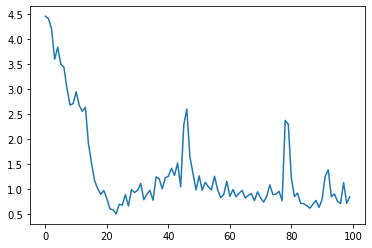

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

exercise : 프런트 레이즈, accuracy : 0.4000
exercise : 바벨 로우, accuracy : 0.4500
exercise : 바벨 데드리프트, accuracy : 0.1071
exercise : 바벨 스쿼트, accuracy : 0.5926
exercise : 바벨 런지, accuracy : 0.5789
exercise : 덤벨 체스트 플라이, accuracy : 1.0000
exercise : 라잉 레그 레이즈, accuracy : 0.7143
exercise : 크런치, accuracy : 0.8519
exercise : 바이시클 크런치, accuracy : 0.6522
exercise : 힙쓰러스트, accuracy : 0.9130
exercise : 푸시업, accuracy : 0.8500
exercise : Y - Exercise, accuracy : 0.9615
exercise : 딥스, accuracy : 0.7143
exercise : 로잉머신, accuracy : 0.9333


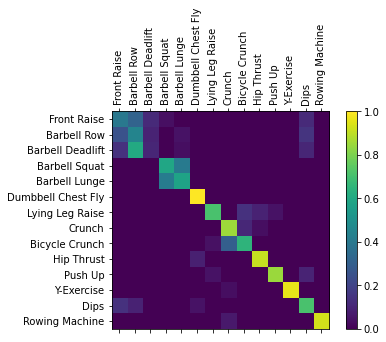

<Figure size 3600x3600 with 0 Axes>

In [34]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, input_sequence = randomTrainingExampleBatch(1,'test',i)
    cat_num = int(category_tensor[0])
    category = exer_uniq[cat_num % n_categories]
            
    float_input = input_sequence
    if torch.cuda.is_available():
      float_input = input_sequence.type(torch.cuda.FloatTensor)
    else:
      float_input = input_sequence.type(torch.FloatTensor)

    inpfloat_input = float_input.to(device)
    output = rnn(float_input)
    guess, guess_i = categoryFromOutput(output)
    category_i = exer_uniq.tolist().index(category)
    confusion[category_i][guess_i] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    print("exercise : %s, accuracy : %.4f"%(exer_uniq[i],confusion[i][i]))

# Set up plot
fig = plt.figure()
plt.figure(figsize=(50,50))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes

ax.set_xticklabels([''] + exer_eng, rotation=90)
ax.set_yticklabels([''] + exer_eng)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()